In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
from pandas import to_datetime
import seaborn as sn
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr, iqr

In [2]:
customer_indicators = pd.read_csv("../../indicators.csv", index_col=0)
customer_indicators

,I,Iu,spending,Imax,avg_bought,baskets,E
CustomerID,,,,,,,
12347.0,0.108021,0.059890,0.124483,0.217940,0.019291,0.031579,0.628584
12348.0,0.002658,0.003964,0.071554,0.002658,0.274122,0.000000,0.000000
12349.0,0.307641,0.311199,0.368923,0.307641,0.023277,0.000000,0.585006
12350.0,0.112957,0.073340,0.081727,0.112957,0.008866,0.000000,0.393407
12352.0,0.044423,0.037944,0.064072,0.067110,0.033188,0.031579,0.551425
...,...,...,...,...,...,...,...
18280.0,0.028571,0.048563,0.053783,0.028571,0.030539,0.000000,0.324265
18281.0,0.033223,0.023786,0.013787,0.033223,0.005147,0.000000,0.230642
18282.0,0.016279,0.021308,0.020487,0.017276,0.025711,0.005263,0.299490


In [3]:
def target_label(row):
    first_third = customer_indicators["spending"].quantile(0.33)
    second_third = customer_indicators["spending"].quantile(0.66)
    if (row["spending"] <= first_third):
        return 1
    elif (row["spending"] > first_third and row["spending"] <= second_third):
        return 2
    return 3

customer_indicators["label"] = customer_indicators.apply(target_label, axis=1)

In [4]:
customer_indicators

,I,Iu,spending,Imax,avg_bought,baskets,E,label
CustomerID,,,,,,,,
12347.0,0.108021,0.059890,0.124483,0.217940,0.019291,0.031579,0.628584,3
12348.0,0.002658,0.003964,0.071554,0.002658,0.274122,0.000000,0.000000,2
12349.0,0.307641,0.311199,0.368923,0.307641,0.023277,0.000000,0.585006,3
12350.0,0.112957,0.073340,0.081727,0.112957,0.008866,0.000000,0.393407,3
12352.0,0.044423,0.037944,0.064072,0.067110,0.033188,0.031579,0.551425,2
...,...,...,...,...,...,...,...,...
18280.0,0.028571,0.048563,0.053783,0.028571,0.030539,0.000000,0.324265,2
18281.0,0.033223,0.023786,0.013787,0.033223,0.005147,0.000000,0.230642,1
18282.0,0.016279,0.021308,0.020487,0.017276,0.025711,0.005263,0.299490,1


## Classificazione con Random Forest

In [5]:
from sklearn.model_selection import train_test_split

customer_indicatorsForClass=customer_indicators.copy()

#extract and remove original label values
originalLabel=customer_indicatorsForClass["label"].values
customer_indicatorsForClass=customer_indicatorsForClass.drop(columns=['label'])
#generate training and test set
train_set, test_set, train_label, test_label = train_test_split(customer_indicatorsForClass, originalLabel, stratify =originalLabel, test_size=0.40)

In [6]:
print(train_set)
print(train_label.shape)
print(test_set)
print(test_label.shape)

                   I        Iu  spending      Imax  avg_bought   baskets  \
CustomerID                                                                 
15379.0     0.130138  0.083251  0.123044  0.308306    0.017307  0.031579   
13266.0     0.053710  0.021721  0.039638  0.089037    0.011468  0.057895   
15397.0     0.011960  0.028741  0.027873  0.011960    0.031702  0.000000   
16105.0     0.039867  0.028741  0.030625  0.039867    0.009465  0.000000   
14020.0     0.078405  0.065907  0.071133  0.083056    0.017641  0.005263   
...              ...       ...       ...       ...         ...       ...   
13271.0     0.106312  0.187314  0.036459  0.106312    0.004485  0.000000   
17639.0     0.001329  0.008920  0.011656  0.001329    0.066383  0.000000   
17017.0     0.040567  0.013875  0.038887  0.130233    0.012692  0.094737   
12610.0     0.079468  0.064420  0.087653  0.186047    0.023807  0.021053   
16409.0     0.104718  0.093162  0.086673  0.180731    0.012382  0.021053   

           

## Grid search per la ricerca dei parametri migliori

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

#define the parameters' values you want to try
param_dist = {"max_depth": [2,3,4,5,6,7,10,12,None],
              "max_features": [2,3],
              "min_samples_split": sp_randint(10, 100),
              "min_samples_leaf": sp_randint(10, 100),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None]}
#define the number of iters
n_iter_search = 50
#define the model
clf = RandomForestClassifier(n_estimators=30)
#define the grid search
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(train_set, train_label)

print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])


Best setting parameters  {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 2, 'min_samples_leaf': 82, 'min_samples_split': 37}
Mean and std of this setting  0.9871275847858232 0.00726632623313374


In [9]:
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='entropy',
                             max_features=3,
                             max_depth=3, 
                             min_samples_split=13,
                             min_samples_leaf=90,
                             bootstrap=False) 
rf = rf.fit(train_set, train_label)

In [10]:
#prediction on the test test
test_pred_rf = rf.predict(test_set)

In [11]:
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=["1","2","3"]))
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

           1       1.00      0.97      0.98       547
           2       0.97      1.00      0.98       547
           3       1.00      1.00      1.00       564

    accuracy                           0.99      1658
   macro avg       0.99      0.99      0.99      1658
weighted avg       0.99      0.99      0.99      1658



In [12]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    conf = confusion_matrix(y_true, y_pred)
    ax = sn.heatmap(conf, annot=True)
    ax.set(xlabel = "Predicted label", ylabel = "True label")

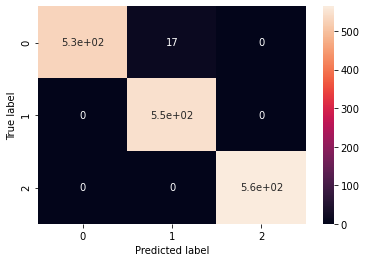

In [13]:
plot_confusion_matrix(test_label, test_pred_rf)

## Classificazione con Naive Bayes

In [14]:
#import, define and fit the model
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(train_set, train_label)

#predict on the test set
test_pred_gnb = gnb.predict(test_set)

In [15]:
#compute the performance of the model
report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

           1       0.90      0.91      0.91       547
           2       0.78      0.84      0.81       547
           3       0.92      0.84      0.88       564

    accuracy                           0.86      1658
   macro avg       0.87      0.86      0.86      1658
weighted avg       0.87      0.86      0.86      1658



(0.0, 0.4)

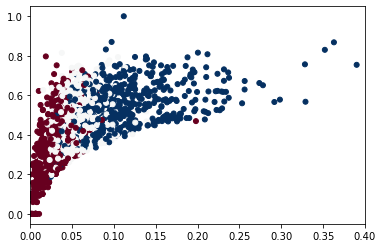

In [28]:
from sklearn.datasets import make_blobs
plt.scatter(test_set["I"], test_set["E"], c=test_label, s=25, cmap='RdBu')
plt.xlim(0, 0.4)


(0.0, 0.4)

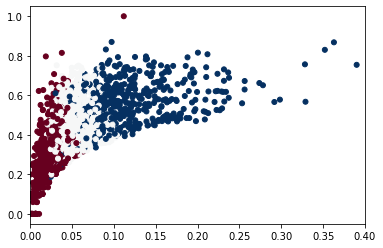

In [29]:
plt.scatter(test_set["I"], test_set["E"], c=test_pred_gnb, s=25, cmap='RdBu')
plt.xlim(0, 0.4)